In [3]:
import pygame
import numpy as np

class ElasticTissueEnv:
    def __init__(self, render_mode=None, image_size=(120, 120)):
        # Simulation parameters
        self.GRID_WIDTH = 10
        self.GRID_HEIGHT = 10
        self.PARTICLE_COUNT = self.GRID_WIDTH * self.GRID_HEIGHT 
        self.SPRING_K = 1000.0
        self.DAMPING = .99
        self.GRAVITY = np.array([0.0, 10.0])
        self.dt = 0.016
        self.sub_steps = 16
        
        # Environment parameters
        self.render_mode = render_mode
        self.max_gripper_step = 10.0
        self.image_size = image_size
        
        # Store default gripper positions
        self.default_left_gripper = None
        self.default_right_gripper = None
        
        # Action and observation spaces
        self.action_space_low = -1.0
        self.action_space_high = 1.0
        self.action_space_shape = (4,)
        
        # Colors for rendering
        self.WHITE = (255, 255, 255)
        self.BLUE = (0, 0, 255)
        self.RED = (255, 0, 0)
        self.CLOTH_COLOR = (156, 197, 255)  # Light blue for cloth
        self.CLOTH_OUTLINE = (106, 147, 205)  # Darker blue for outline
        
        # Gripper size
        self.GRIPPER_RADIUS = 2  # Smaller gripper radius
        
        # Initialize offscreen surface for image observations
        self.base_width = 800
        self.base_height = 600
        pygame.init()
        if self.render_mode == "human":
            self.screen = pygame.display.set_mode((self.base_width, self.base_height))
            pygame.display.set_caption("Elastic Tissue Simulation")
            self.clock = pygame.time.Clock()
        
        # Create offscreen surface for image observations
        self.offscreen_surface = pygame.Surface((self.base_width, self.base_height))
        
        # Initialize simulation
        self.reset()

    def _get_cloth_polygon(self):
        # Collect only boundary particles for a single outer polygon
        boundary = []
        # top row
        for j in range(self.GRID_WIDTH):
            boundary.append(self.particles[j, :2].astype(int))
        # right column
        for i in range(1, self.GRID_HEIGHT):
            boundary.append(self.particles[i*self.GRID_WIDTH + (self.GRID_WIDTH - 1), :2].astype(int))
        # bottom row
        for j in range(self.GRID_WIDTH - 2, -1, -1):
            boundary.append(self.particles[(self.GRID_HEIGHT - 1)*self.GRID_WIDTH + j, :2].astype(int))
        # left column
        for i in range(self.GRID_HEIGHT - 2, 0, -1):
            boundary.append(self.particles[i*self.GRID_WIDTH, :2].astype(int))
        return boundary

    def _render_to_surface(self, surface):
        """Render the current state to the given surface"""
        surface.fill(self.WHITE)
        
        # Get cloth vertices
        vertices = self._get_cloth_polygon()
        
        # Draw filled cloth
        if len(vertices) >= 3:  # Need at least 3 vertices to draw a polygon
            pygame.draw.polygon(surface, self.CLOTH_COLOR, vertices)
            
            # Draw cloth outline
            pygame.draw.polygon(surface, self.CLOTH_OUTLINE, vertices, 1)
        
        # Draw grippers (smaller circles)
        for gripper_pos in self.grippers:
            pygame.draw.circle(surface, self.BLUE, gripper_pos.astype(int), self.GRIPPER_RADIUS)

    def get_image_observation(self):
        """
        Returns an RGB image observation of the current state
        
        Returns:
            numpy array of shape (H, W, 3) containing the RGB image
        """
        # Render to offscreen surface
        self._render_to_surface(self.offscreen_surface)
        
        # Get pixel array from surface
        pixel_array = pygame.surfarray.array3d(self.offscreen_surface)
        
        # Transpose to get (H, W, 3) format
        pixel_array = pixel_array.transpose(1, 0, 2)
        
        # Resize to desired observation size
        if pixel_array.shape[:2] != self.image_size:
            import cv2
            pixel_array = cv2.resize(pixel_array, self.image_size, 
                                   interpolation=cv2.INTER_AREA)
        
        return pixel_array

    def render(self):
        if self.render_mode != "human":
            return
            
        # Render to main screen
        self._render_to_surface(self.screen)
        pygame.display.flip()
        self.clock.tick(60)
                
    def step(self, action):
        """
        Takes an action and returns observation, reward, done, info
        
        Args:
            action: numpy array [left_dx, left_dy, right_dx, right_dy] in range [-1, 1]
        """
        # Ensure action is float array
        action = np.array(action, dtype=np.float64)
        
        # Scale normalized actions to actual distances
        action = np.clip(action, self.action_space_low, self.action_space_high)
        scaled_action = action * self.max_gripper_step
        
        # Update gripper positions
        self.grippers[0] += scaled_action[:2]  # Left gripper
        self.grippers[1] += scaled_action[2:]  # Right gripper
        
        # Enforce bounds on gripper positions
        # self.grippers = np.clip(
        #     self.grippers,
        #     [0.0, 0.0],
        #     [float(self.base_width), float(self.base_height)]
        # )
        # self.grippers[0] = np.clip(
        #     self.grippers[0],
        #     [0.0, float(self.base_height)/2],
        #     [float(self.base_width)/3, float(self.base_height)]
        # )
        # self.grippers[1] = np.clip(
        #     self.grippers[1],
        #     [float(self.base_width)/2, float(self.base_height)/2],
        #     [float(self.base_width), float(self.base_height)]
        # )
        
        # Update physics
        self._update_physics()
        
        # Get observations
        state_obs = self._get_observation()
        image_obs = self.get_image_observation()
        
        observation = {
            'state': state_obs,
            'image': image_obs
        }
        
        # Simple reward based on gripper movement (can be customized)
        reward = 0.0
        
        # Episode never ends
        done = False
        
        # Additional info
        info = {
            "gripper_positions": self.grippers.copy(),
            "particle_positions": self.particles[:, :2].copy()
        }
        
        return observation, reward, done, info

    def set_gripper_positions(self, left_pos=None, right_pos=None):
        """
        Set the initial positions of the grippers. These positions will be used on reset.
        
        Args:
            left_pos: tuple/list/array of (x, y) for left gripper
            right_pos: tuple/list/array of (x, y) for right gripper
            
        If either position is None, it will use the default position for that gripper.
        """
        # Convert inputs to float arrays if provided
        if left_pos is not None:
            self.default_left_gripper = np.array(left_pos, dtype=np.float64)
        if right_pos is not None:
            self.default_right_gripper = np.array(right_pos, dtype=np.float64)
            
        # Update current gripper positions if simulation is already running
        if hasattr(self, 'grippers'):
            if left_pos is not None:
                self.grippers[0] = self.default_left_gripper.copy()
            if right_pos is not None:
                self.grippers[1] = self.default_right_gripper.copy()
            
            # Update attached particles
            self.particles[0, :2] = self.grippers[0]  # Left gripper
            self.particles[self.GRID_WIDTH-1, :2] = self.grippers[1]  # Right gripper
        
        self._update_physics()

    def reset(self):
        # Initialize particle positions in a grid
        spacing_x = 40
        spacing_y = 40
        start_x = 400 - (self.GRID_WIDTH * spacing_x) // 2
        start_y = 200
        
        # Set default gripper positions if not already set
        if self.default_left_gripper is None:
            self.default_left_gripper = np.array([float(start_x), float(start_y)], dtype=np.float64)
        if self.default_right_gripper is None:
            self.default_right_gripper = np.array(
                [float(start_x + (self.GRID_WIDTH - 1) * spacing_x), float(start_y)], 
                dtype=np.float64
            )
        
        # Initialize grippers with default positions
        self.grippers = np.stack([
            self.default_left_gripper.copy(),
            self.default_right_gripper.copy()
        ])
        
        # Particle properties: x, y, vx, vy
        self.particles = np.zeros((self.PARTICLE_COUNT, 4), dtype=np.float64)
        
        # Set initial positions
        for i in range(self.GRID_HEIGHT):
            for j in range(self.GRID_WIDTH):
                idx = i * self.GRID_WIDTH + j
                if j == 0:  # Left edge
                    self.particles[idx, 0] = self.grippers[0, 0]
                elif j == self.GRID_WIDTH - 1:  # Right edge
                    self.particles[idx, 0] = self.grippers[1, 0]
                else:  # Interpolate between grippers
                    t = j / (self.GRID_WIDTH - 1)
                    self.particles[idx, 0] = (1 - t) * self.grippers[0, 0] + t * self.grippers[1, 0]
                self.particles[idx, 1] = start_y + i * spacing_y
        
        # Fixed particles (bottom row is anchored)
        self.fixed_particles = np.zeros(self.PARTICLE_COUNT, dtype=bool)
        bottom_row_indices = np.arange(
            self.PARTICLE_COUNT - self.GRID_WIDTH, 
            self.PARTICLE_COUNT
        )
        self.fixed_particles[bottom_row_indices] = True
        
        # Spring connections
        self.springs = []
        # Horizontal springs
        for i in range(self.GRID_HEIGHT):
            for j in range(self.GRID_WIDTH - 1):
                idx1 = i * self.GRID_WIDTH + j
                idx2 = i * self.GRID_WIDTH + j + 1
                self.springs.append((idx1, idx2))
        
        # Vertical springs
        for i in range(self.GRID_HEIGHT - 1):
            for j in range(self.GRID_WIDTH):
                idx1 = i * self.GRID_WIDTH + j
                idx2 = (i + 1) * self.GRID_WIDTH + j
                self.springs.append((idx1, idx2))
        
        return self._get_observation()

    def _update_physics(self):
        dt = self.dt / self.sub_steps
        
        for _ in range(self.sub_steps):
            # Reset forces
            forces = np.zeros_like(self.particles[:, :2])
            forces += self.GRAVITY
            
            # Spring forces
            for spring in self.springs:
                idx1, idx2 = spring
                pos1 = self.particles[idx1, :2]
                pos2 = self.particles[idx2, :2]
                
                delta = pos2 - pos1
                distance = np.linalg.norm(delta)
                if distance > 0:
                    # Spring force
                    rest_length = 40  # Same as initial spacing
                    force = self.SPRING_K * (distance - rest_length)
                    direction = delta / distance
                    spring_force = force * direction
                    
                    if not self.fixed_particles[idx1]:
                        forces[idx1] += spring_force
                    if not self.fixed_particles[idx2]:
                        forces[idx2] -= spring_force
            
            # Update velocities and positions
            self.particles[:, 2:4] += forces * dt
            self.particles[:, 2:4] *= self.DAMPING
            
            # Update positions for non-fixed particles
            mask = ~self.fixed_particles
            self.particles[mask, :2] += self.particles[mask, 2:4] * dt
            
            # Update gripper-attached particles (top row)
            self.particles[0, :2] = self.grippers[0]  # Left gripper
            self.particles[self.GRID_WIDTH-1, :2] = self.grippers[1]  # Right gripper

    def _get_observation(self):
        """Returns the current state of the environment"""
        return {
            "particle_positions": self.particles[:, :2].copy(),
            "particle_velocities": self.particles[:, 2:4].copy(),
            "gripper_positions": self.grippers.copy()
        }

    def close(self):
        if self.render_mode == "human":
            pygame.quit()

In [4]:
if __name__ == "__main__":
    # Create environment
    env = ElasticTissueEnv(render_mode="human")
    
    # Simple control loop
    running = True
    while running:
        # Random action for demonstration
        action = np.random.uniform(-1, 1, 4)
        # Step the environment
        obs, reward, done, info = env.step(action)
        # Render
        env.render()
        
        # Check for quit
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            if event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE:
                running = False
    
    env.close()

In [64]:
obs['state']['gripper_positions']

array([[184.01943965, 241.64514495],
       [560.67099189, 236.74492974]])

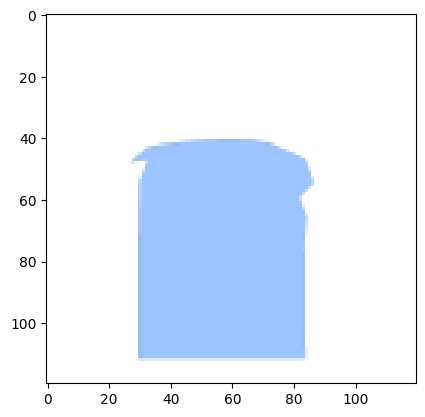

In [65]:
import matplotlib.pyplot as plt

plt.imshow(obs['image'])

In [27]:
import time
if __name__ == "__main__":
    # Create environment
    env = ElasticTissueEnv(render_mode="human")

    # randomnly select two points on the display and move the grippers to those points
    point0 = np.random.uniform(0, -800, 2)
    point1 = np.random.uniform(0, -600, 2)
    print(point0, point1)

    # Simple control loop
    running = True
    while running:
        # select action to move gripper to point0 and point1
        action = np.array([point0[0], point0[1], point1[0], point1[1]])
        
        env.step(action)
        env.render()

        # Check for quit
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            if event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE:
                running = False
    
    env.close()

[-164.72613602  -59.73292173] [-460.30812728 -113.88945476]


In [12]:
start = np.array([0, 0])
end = np.array([8, 6])
np.arange(start,end)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()